In [ ]:
'''
Create a dataframe with the images and labels we can use to preprocess the data
The dataframe has 2 columns: image and label, where the image is the path to the image
and the label is the classification of the image. I had to keep the images stored as
a filepath, beucase the colab session would keep crashing because beucase I do not have enough ram
'''
import os
import pandas as pd

ALZ_DIR = "/AugmentedAlzheimerDataset"
images = []

subfolder_mapping = {
    "AD" : "Alzheimers_Disease",
    "CN" : "Normal",
    "EMCI" : "Early_Mild_Cognitive_Impairment",
    "LMCI" : "Late_Mild_Cognitive_Impairment"
}

for subdir in os.listdir(ALZ_DIR):
  # kaggle puts in a weird hidden dir called .tmp.driveupload
  if subdir.startswith("."):
    continue

  label = subfolder_mapping[subdir]
  for image_path in os.listdir(os.path.join(ALZ_DIR, subdir)):
    full_image_path = os.path.join(ALZ_DIR, subdir, image_path)
    images.append({'image':full_image_path, 'label':label})

img_dataframe = pd.DataFrame(images)
img_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33984 entries, 0 to 33983
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   33984 non-null  object
 1   label   33984 non-null  object
dtypes: object(2)
memory usage: 531.1+ KB


label
Early_Mild_Cognitive_Impairment    9600
Late_Mild_Cognitive_Impairment     8960
Alzheimers_Disease                 8960
Normal                             6464
Name: count, dtype: int64


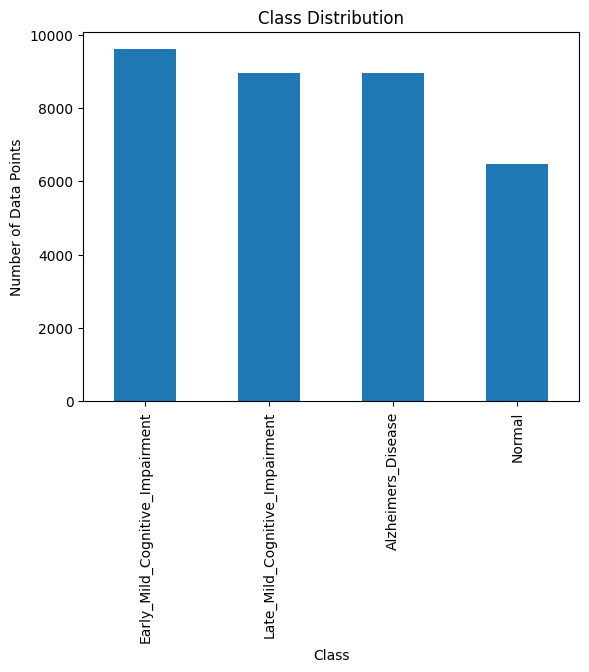

In [4]:
'''
Class distributions
'''
import matplotlib.pyplot as plt

class_distributions = img_dataframe['label'].value_counts()
print(class_distributions)

class_distributions.plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Data Points")
plt.show()

In [5]:
print(class_distributions.mean() - class_distributions.Normal)
print((class_distributions.mean() - class_distributions.Normal) / class_distributions.sum())

2032.0
0.059792843691148775


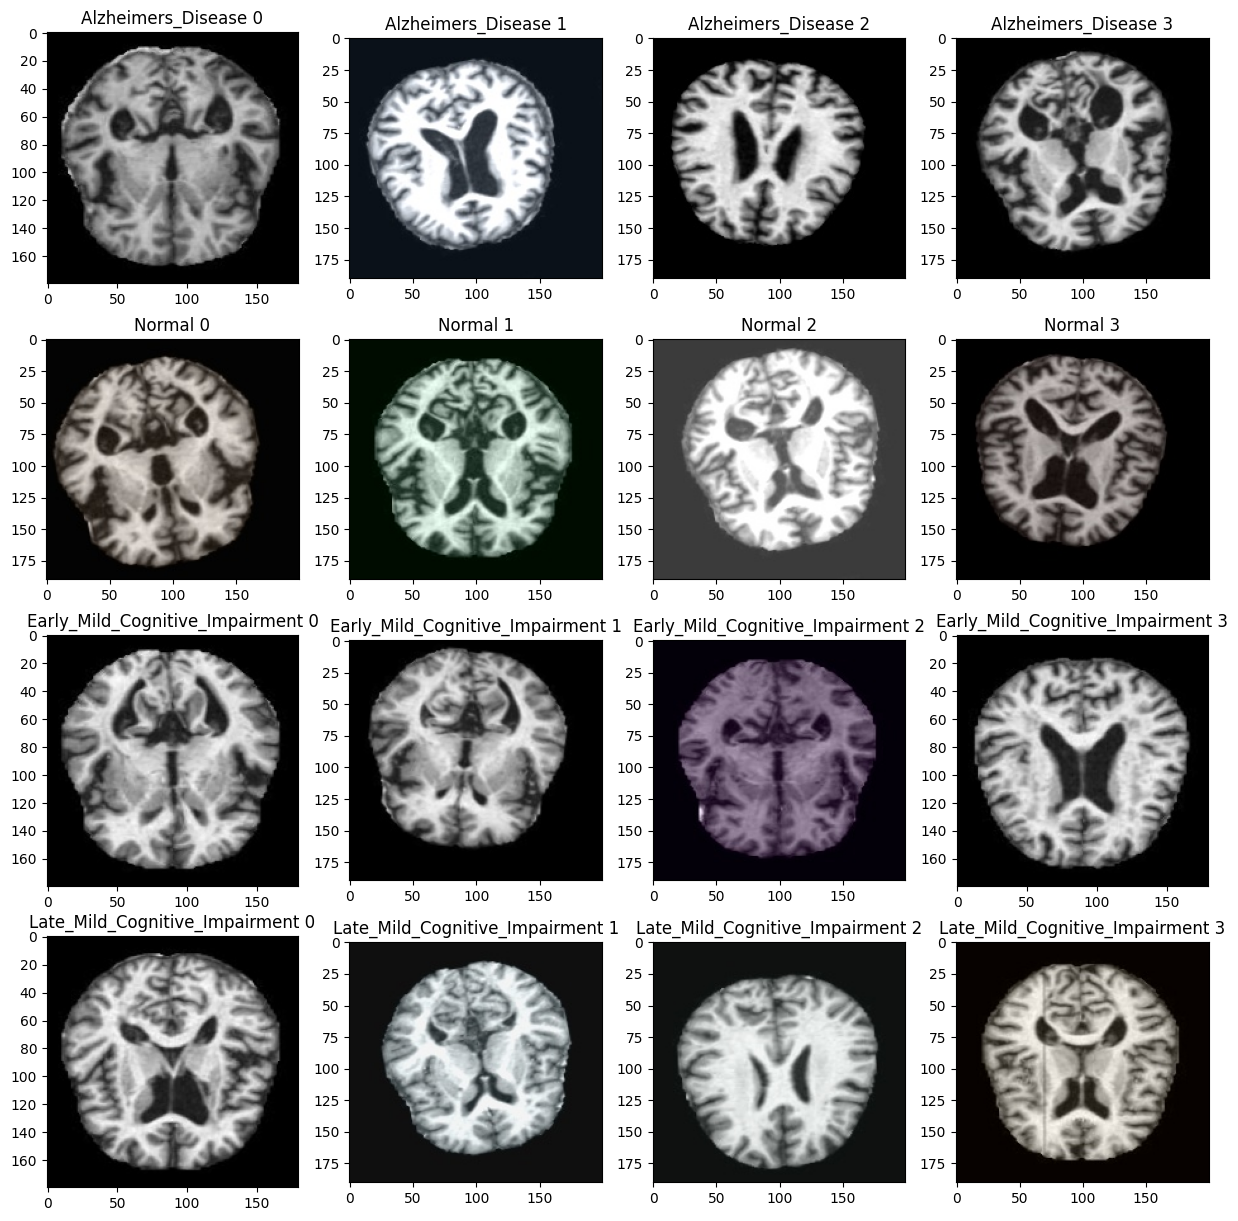

In [6]:
'''
Plot a couple of images from each classification to see what they look like
'''
import PIL
unique_lables = subfolder_mapping.values()
num_cols = 4

plt.figure(figsize=(15, 15))
for index, label in zip(range(num_cols), unique_lables):
  for image_num in range(num_cols):
    plt.subplot(4, num_cols, index*num_cols + image_num+1)
    image = PIL.Image.open(img_dataframe[img_dataframe['label'] == label]['image'].to_list()[image_num+1])
    plt.imshow(image)
    plt.title(f"{label} {image_num}")

In [7]:
'''
Figure out the size and what kind of the images they are so I can scale down/up
'''
# for some reason I needed to use the iloc command
original_img = PIL.Image.open(img_dataframe['image'].iloc[0])
print(f"Size of images are: {original_img.size}")
print(f"The image is: {original_img.mode}")

Size of images are: (200, 190)
The image is: RGB


This is intersting becuase MRI's are typically grayscale as they are constructued images

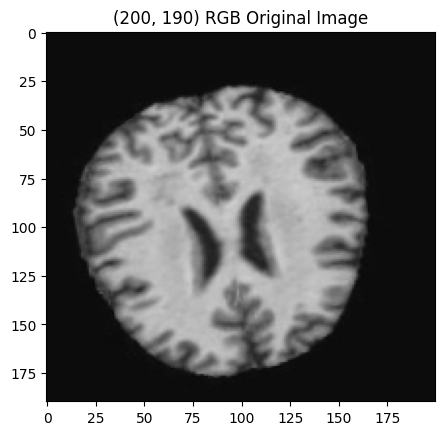

In [8]:
'''
See what a singular image looks like with its dimensions
'''
original_img = PIL.Image.open(img_dataframe['image'].iloc[0])
plt.imshow(original_img)
plt.title(f"{original_img.size} RGB Original Image")
plt.show()

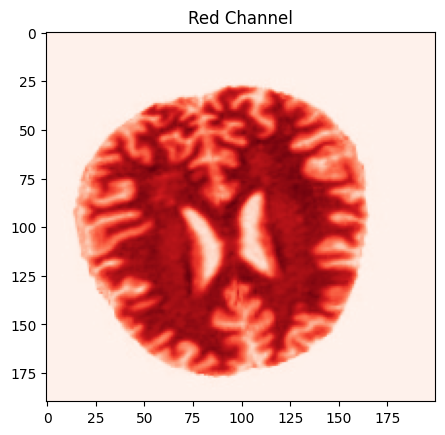

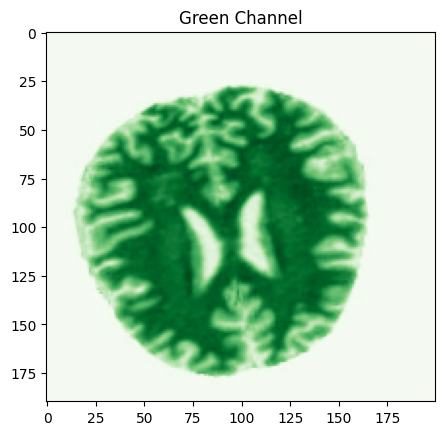

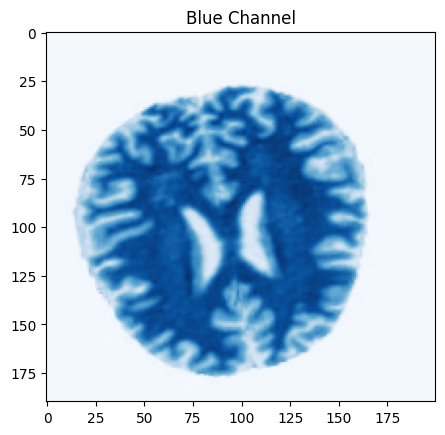

In [9]:
'''
Show the three color channels for the images
'''
original_img = PIL.Image.open(img_dataframe['image'].iloc[0])
r, g, b = original_img.split()
plt.imshow(r, cmap='Reds')
plt.title("Red Channel")
plt.show()
plt.imshow(g, cmap='Greens')
plt.title("Green Channel")
plt.show()
plt.imshow(b, cmap='Blues')
plt.title("Blue Channel")
plt.show()

These look like they are the grayscale version of the image in all 3 color channels, so its just the same channel duplicated three times.

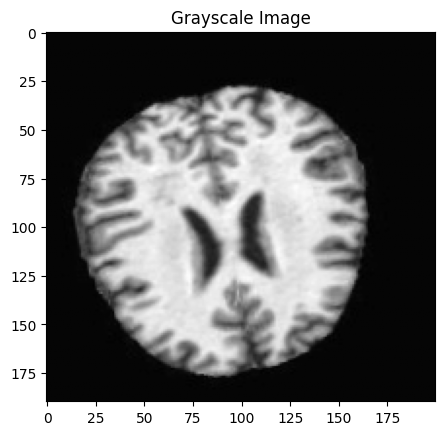

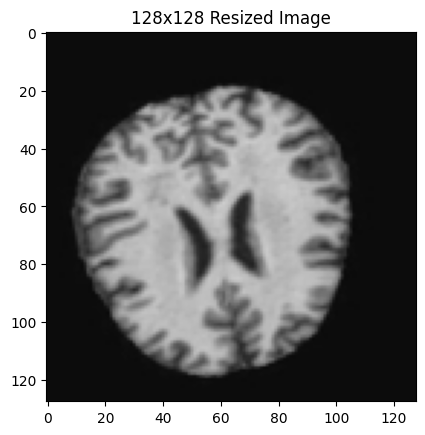

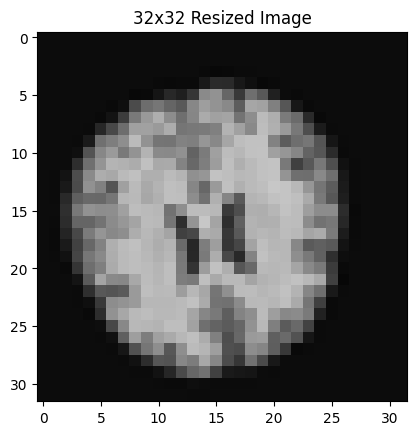

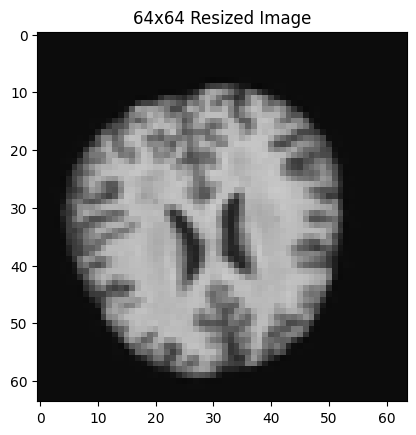

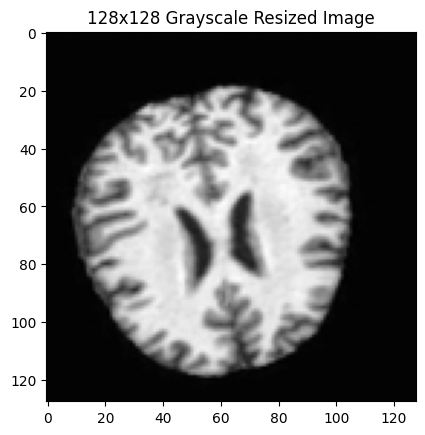

In [10]:
'''
Playing around with the preprocessing and try to see what happens to the images at
different sizes
'''
original_img = PIL.Image.open(img_dataframe['image'].iloc[0])
grayscale_converted_img = original_img.convert('L')
plt.imshow(grayscale_converted_img, cmap='gray')
plt.title("Grayscale Image")
plt.show()

resized_img = original_img.resize((128, 128))
plt.imshow(resized_img)
plt.title("128x128 Resized Image")
plt.show()

resized_img = original_img.resize((32, 32))
plt.imshow(resized_img)
plt.title("32x32 Resized Image")
plt.show()

resized_img = original_img.resize((64, 64))
plt.imshow(resized_img)
plt.title("64x64 Resized Image")
plt.show()

grayscale_resized_img = original_img.convert('L').resize((128, 128))
plt.imshow(grayscale_resized_img, cmap='gray')
plt.title("128x128 Grayscale Resized Image")
plt.show()

The best size for this is probably the 128x128 becuase it does not seem to lose any data/resolution, however, it is smaller so the computational time is quickker.

In [11]:
'''
I wanted to try to figure out a different way to load in the data becuase my models
were overfitting with less data and my colab session would crash if I loaded it all in.
I found this which should let me lazy load the images from hard drive
(not sure if it will work but its worth a shot)
https://medium.com/@rami.zaboura/leveraging-tensorflows-built-in-parallelism-and-lazy-data-loading-using-data-dataset-api-1c09cc454372

update: it worked
'''
import tensorflow as tf

def generate_datasets(train_data, valid_data, map_function, batch_size=32):
  # create a tensorflow dataset using the splits I already created with sklearn
  # then map my preprocess function (you have to use the tensorflow functions)
  # then say how many images you want to load in each batch
  # then specify how you want to prefetch batches to make the process faster
  train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
  train_dataset = train_dataset.map(map_function)
  train_dataset = train_dataset.batch(batch_size)
  train_dataset = train_dataset.prefetch(1)

  valid_dataset = tf.data.Dataset.from_tensor_slices(valid_data)
  valid_dataset = valid_dataset.map(map_function)
  valid_dataset = valid_dataset.batch(batch_size)
  valid_dataset = valid_dataset.prefetch(1)

  return train_dataset, valid_dataset

In [12]:
'''
Preprocess the images. for preprocessing, I resized the images down to 128x128
as it ensures the images do not lose too much information, yet is small enough
to have somewhat fast computation speed with a GPU. I also converted to grayscale
because the images are created with only one color channel.
I also scaled the pixel values to be between 0 and 1.

Future work could (and probably should) include data augmentation
'''
import numpy as np

#the funcitons within these have to be from tesnorflow
def load_and_preprocess_image(path, label, size=(128, 128), channels=1):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=channels)
  img = tf.image.resize(img, size)
  img = tf.cast(img, tf.float32) / 255.0
  return img, label


# load in the testing data at the specific size
def load_testing_data(paths, labels, model_type=None, size=(128, 128), channels=1):
  images = []
  for i in range(len(paths)):
    img, label = load_and_preprocess_image(paths[i], labels[i], size=size, channels=channels)
    images.append(img.numpy())

  return np.array(images)

In [34]:
'''
Function to evaluate the model(s), I am primarily interested in the accuracy and
F1 scores as well as the confusion matrix to see what is potentially being misclassified.
'''
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
import matplotlib.pyplot as plt

def generate_classification_report(model, X_test, y_test, label_encoder):
  y_proba = model.predict(X_test)
  y_pred = y_proba.argmax(axis=1)

  print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
  print(f"F1 score: {f1_score(y_test, y_pred, average='macro')}")

  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()
  print("\n")
  print(dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_)))

In [14]:
'''
Function for plotting a learning curve (copied from notes)
'''
import matplotlib.pyplot as plt

def plot_learning_curve(history, title):
  pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
  plt.legend(loc="lower left")  # extra code
  plt.title(title)
  plt.show()

In [15]:
'''
Split the data into training and testing sets and encode the labels to numerical form
'''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X, y = img_dataframe['image'].to_numpy(), img_dataframe['label'].to_numpy()

label_encoder = LabelEncoder()
y_labeled = label_encoder.fit_transform(y)
print(dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))) # this code was from stackoverflow

# split into testing and training
X_train, X_test, y_train, y_test = train_test_split(X, y_labeled, test_size=0.2, random_state=42, shuffle=True)

# split the trianing once more into training and validation (80/20 again)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

print(f"Train data size: {len(X_train)}")
print(f"Validation data size: {len(X_valid)}")
print(f"Test data size: {len(X_test)}")

train_data, valid_data = generate_datasets((X_train, y_train), (X_valid, y_valid), lambda path, label: load_and_preprocess_image(path, label, size=(128, 128), channels=1))

# load in the test images, I dont have to worry about ram with these ones anymore
# becuase of how I ended up handling the dataset stuff
X_test_img = load_testing_data(X_test, y_test, size=(128, 128), channels=1)

print(len(X_test) == len(X_test_img))

{np.int64(0): 'Alzheimers_Disease', np.int64(1): 'Early_Mild_Cognitive_Impairment', np.int64(2): 'Late_Mild_Cognitive_Impairment', np.int64(3): 'Normal'}
Train data size: 21749
Validation data size: 5438
Test data size: 6797
True


In [32]:
'''
Create a Basic CNN using some of the code from Lecture 13. Particularly, the
code we use in the transfer learning for the xception, with the GloablPoolingAverage2D
'''
import tensorflow as tf

tf.random.set_seed(42)
tf.keras.backend.clear_session()

# Basic CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[128, 128, 1]), # gets rid of the warning

    tf.keras.layers.Conv2D(filters=64, kernel_size=5, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(filters=128, kernel_size=5, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(units=64, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(units=4, activation="softmax")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.summary()

print("\n")

# train
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_data, epochs=20, validation_data=valid_data)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,067,460 (4.07 MB)

 Trainable params: 1,067,460 (4.07 MB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.2789 - loss: 1.3785 - val_accuracy: 0.3238 - val_loss: 1.3094
Epoch 2/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.3505 - loss: 1.2887 - val_accuracy: 0.5579 - val_loss: 0.9310
Epoch 3/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5441 - loss: 0.9474 - val_accuracy: 0.5897 - val_loss: 0.8335
Epoch 4/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6087 - loss: 0.8088 - val_accuracy: 0.6328 - val_loss: 0.7516
Epoch 5/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6363 - loss: 0.7532 - val_accuracy: 0.6390 - val_loss: 0.7362
Epoch 6/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6633 - loss: 0.7061 - val_accuracy: 0.6859 - val_loss: 0.6427
Epoch 7/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6941 - loss: 0.6534 - val_accuracy: 0.7396 - val_loss: 0.5569
Epoch 8/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7318 - loss: 0.5884 - val_accuracy

My understanding, primarily from this website (https://saturncloud.io/blog/understanding-the-difference-between-flatten-and-globalaveragepooling2d-in-keras/) is that the gloabl average pooling basically combines average pooling with flattening in the sense that it will pool each of the feature maps then output a 1D vector (like flattening) containing the information of all feature maps from the pooling operation. This should allow the model to generalize better becuase its basically just an extra pooling layer, which would reduce the number of parameters and reduce overfitting.

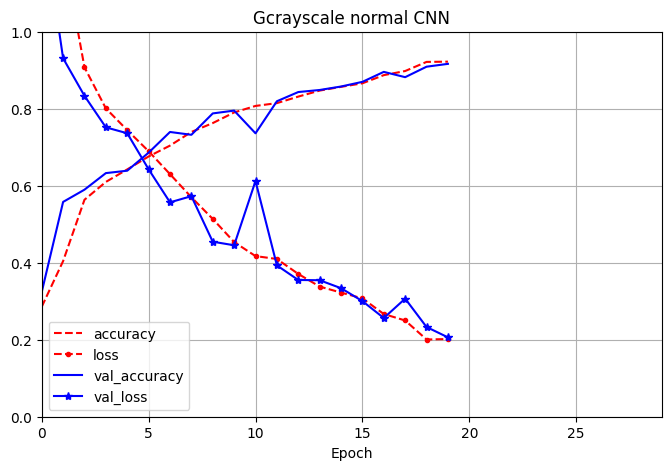

213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Accuracy score: 0.9158452258349272
F1 score: 0.9222924183796741


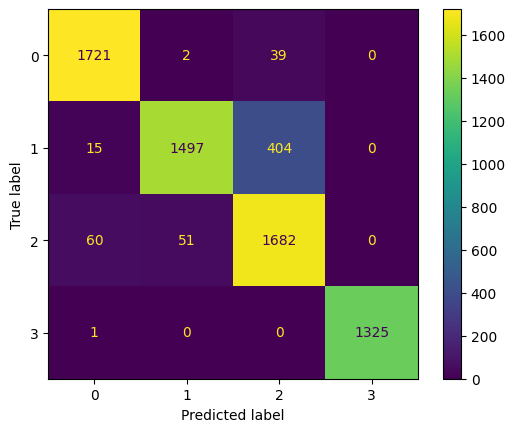



{np.int64(0): 'Alzheimers_Disease', np.int64(1): 'Early_Mild_Cognitive_Impairment', np.int64(2): 'Late_Mild_Cognitive_Impairment', np.int64(3): 'Normal'}


In [33]:
'''
Get the results of the models
'''
plot_learning_curve(history, "Gcrayscale normal CNN")
generate_classification_report(model, X_test_img, y_test, label_encoder)

In [18]:
'''
Test the resnet50 base model with no pretrained weights on the dataset with grayscale
images. I am guessing this is going to overfit becuase there is not much data for
how dense the network is, but I am also hoping I'm wrong
'''
tf.keras.backend.clear_session()

# create a blank resnet50 model to train with, training this from skratch is for consistencies sake
base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(128, 128, 1))

avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(4, activation="softmax")(avg)
resnet_grayscale_model = tf.keras.Model(inputs=base_model.input, outputs=output)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

resnet_grayscale_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = resnet_grayscale_model.fit(train_data, epochs=20, validation_data=valid_data)

Epoch 1/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 102s 70ms/step - accuracy: 0.4747 - loss: 1.4413 - val_accuracy: 0.5706 - val_loss: 1.0357
Epoch 2/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.7143 - loss: 0.6592 - val_accuracy: 0.4697 - val_loss: 1.9126
Epoch 3/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.7993 - loss: 0.4795 - val_accuracy: 0.6460 - val_loss: 0.8849
Epoch 4/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.8450 - loss: 0.3752 - val_accuracy: 0.8100 - val_loss: 0.5572
Epoch 5/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.8817 - loss: 0.2967 - val_accuracy: 0.7977 - val_loss: 0.5418
Epoch 6/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.9079 - loss: 0.2334 - val_accuracy: 0.7974 - val_loss: 0.6752
Epoch 7/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.9220 - loss: 0.2055 - val_accuracy: 0.7865 - val_loss: 0.5666
Epoch 8/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.9376 - loss: 0.1621 -

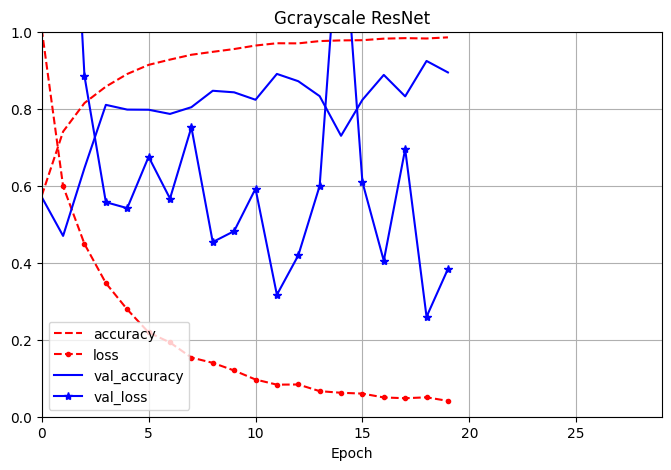

213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step
Accuracy score: 0.8871560982786524
F1 score: 0.8936503953013154


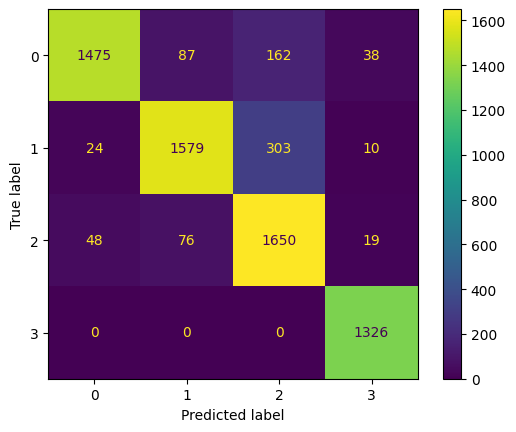



{np.int64(0): 'Alzheimers_Disease', np.int64(1): 'Early_Mild_Cognitive_Impairment', np.int64(2): 'Late_Mild_Cognitive_Impairment', np.int64(3): 'Normal'}


In [19]:
plot_learning_curve(history, "Gcrayscale ResNet")
generate_classification_report(resnet_grayscale_model, X_test_img, y_test, label_encoder)

In [20]:
'''
Try the very basic LeNet model from the notes, I would honestly expect this to
overfit the data a lot since the layers dont have many filters and there are
no dropout layers
'''
tf.keras.backend.clear_session()

# Modified LeNet model with relu instead of tanh becuase the tanh function was AWFUL (~20% accurate)
# Also modified the input layer to be 128x128 to ensure the input image quality is perserved
lenet_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[128, 128, 1]),

    tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='relu'),
    tf.keras.layers.AveragePooling2D(pool_size=2),

    tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation='relu'),
    tf.keras.layers.AveragePooling2D(pool_size=2),

    tf.keras.layers.Conv2D(filters=120, kernel_size=5, activation='relu'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'), # tensorflow doesnt have rbf so I repalced it with relu
    tf.keras.layers.Dense(units=4, activation="softmax")
])

lenet_model.summary()

print("\n")

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

lenet_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = lenet_model.fit(train_data, epochs=20, validation_data=valid_data)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 6)    │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 62, 62, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 58, 58, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 29, 29, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 120)    │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 75000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │     9,000,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           340 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,061,316 (34.57 MB)

 Trainable params: 9,061,316 (34.57 MB)

 Non-trainable params: 0 (0.00 B)



Epoch 1/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.4712 - loss: 1.1026 - val_accuracy: 0.6627 - val_loss: 0.7275
Epoch 2/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7008 - loss: 0.6660 - val_accuracy: 0.7128 - val_loss: 0.6473
Epoch 3/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8008 - loss: 0.4640 - val_accuracy: 0.7951 - val_loss: 0.4887
Epoch 4/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8706 - loss: 0.3162 - val_accuracy: 0.8089 - val_loss: 0.5090
Epoch 5/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9140 - loss: 0.2173 - val_accuracy: 0.8132 - val_loss: 0.5648
Epoch 6/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9413 - loss: 0.1554 - val_accuracy: 0.8244 - val_loss: 0.5194
Epoch 7/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9590 - loss: 0.1115 - val_accuracy: 0.8424 - val_loss: 0.6014
Epoch 8/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9732 - loss: 0.0795 - val_accuracy

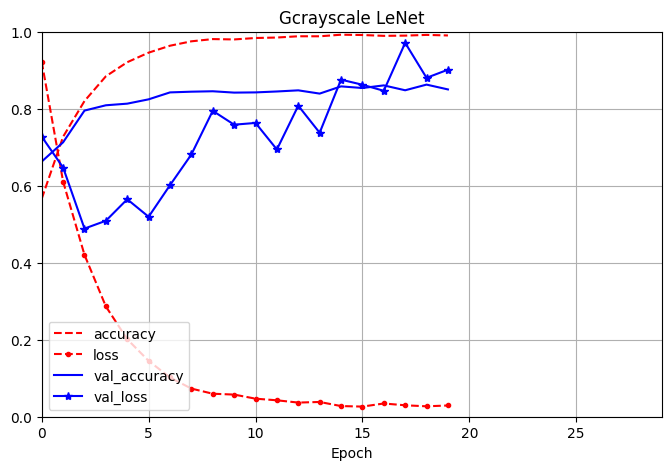

213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Accuracy score: 0.8500809180520817
F1 score: 0.8581336358654299


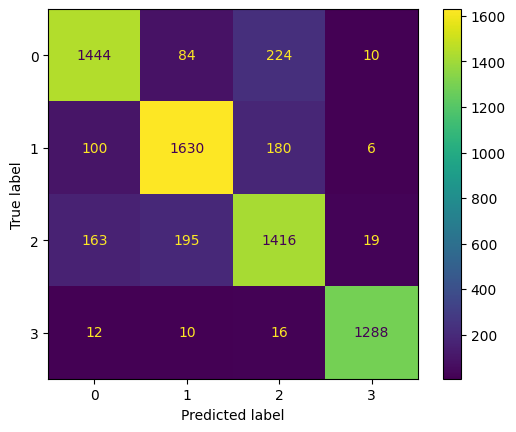



{np.int64(0): 'Alzheimers_Disease', np.int64(1): 'Early_Mild_Cognitive_Impairment', np.int64(2): 'Late_Mild_Cognitive_Impairment', np.int64(3): 'Normal'}


In [21]:
plot_learning_curve(history, "Gcrayscale LeNet")
generate_classification_report(lenet_model, X_test_img, y_test, label_encoder)